In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sys.path.insert(0, '../../')
import ccal
%matplotlib inline

==================== Computational Cancer Analysis Library ====================

<20:54:13.169098> Checking dependencies ...
<20:54:13.171338> Using the following packages:
<20:54:13.173168> 	matplotlib (v1.5.1)
<20:54:13.173186> 	numpy (v1.10.4)
<20:54:13.173196> 	pandas (v0.18.0)
<20:54:13.173216> 	rpy2 (v2.7.9)
<20:54:13.173224> 	scikit-learn (v0.17.1)
<20:54:13.173231> 	scipy (v0.17.0)
<20:54:13.173238> 	seaborn (v0.7.0)


# Load data

In [57]:
features1 = ccal.support.make_random_features(50, 50)
features2 = ccal.support.make_random_features(50, 50)
features = ccal.support.read_gct('../../data/additional_YAP_signatures.gct')

<21:19:02.692367> Features 1 siTAZ_DN (1/14) vs. features 2 ...
<21:19:03.345423> Features 1 siYAP_DN (2/14) vs. features 2 ...
<21:19:03.988686> Features 1 siYAP_TAZ_DN (3/14) vs. features 2 ...
<21:19:04.689326> Features 1 Cordenonsi_et_al_2011_YAP_UP (4/14) vs. features 2 ...
<21:19:05.400249> Features 1 GSE10196_YAP1 (5/14) vs. features 2 ...
<21:19:06.070078> Features 1 GSE10196_YAP1_UP (6/14) vs. features 2 ...
<21:19:06.776017> Features 1 GSE10196_YAP1_DN (7/14) vs. features 2 ...
<21:19:07.491985> Features 1 Zhao_et_al_2008_YAP_UP (8/14) vs. features 2 ...
<21:19:08.204851> Features 1 IPA_YAP1_UP (9/14) vs. features 2 ...
<21:19:08.899175> Features 1 siYAP_TAZ_DN_and_Cordenonsi_et_al_2011_YAP_UP (10/14) vs. features 2 ...
<21:19:09.536245> Features 1 siYAP_TAZ_DN_and_Zhao_et_al_2008_YAP_UP (11/14) vs. features 2 ...
<21:19:10.196582> Features 1 Cordenonsi_et_al_2011_YAP_UP_and_Zhao_et_al_2008_YAP_UP (12/14) vs. features 2 ...
<21:19:10.845376> Features 1 siYAP_TAZ_DN_and_IPA_YA

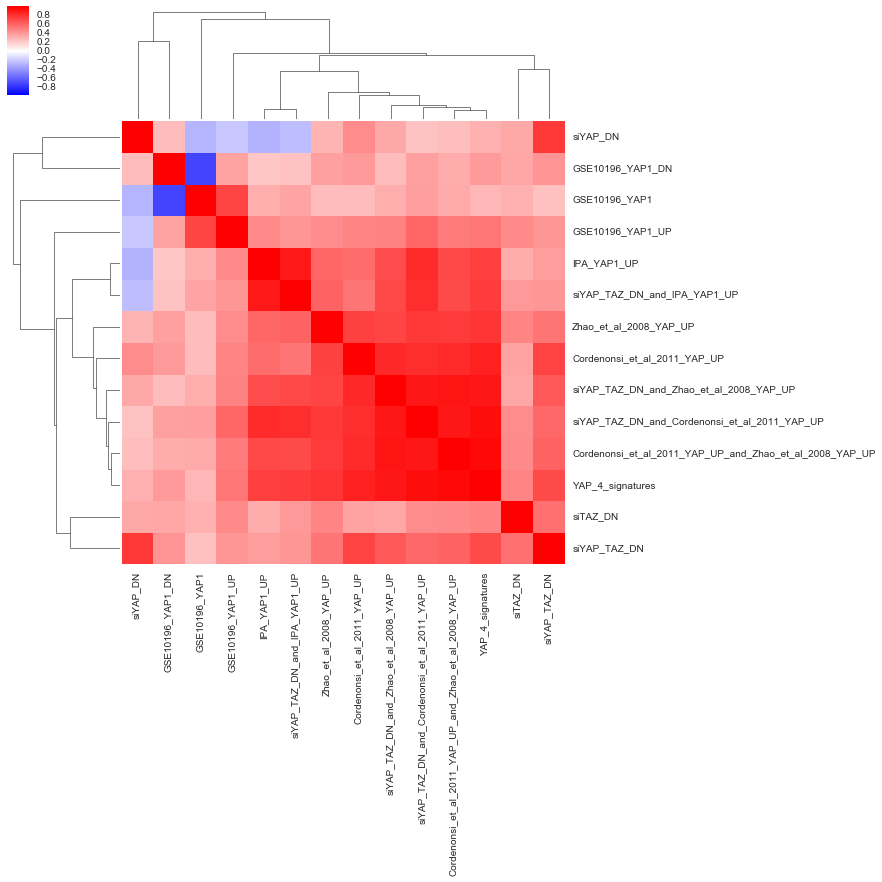

In [63]:
ccal.analyze.rank_features_against_features(features, features)

<21:18:45.516664> Features 1 siTAZ_DN (1/14) vs. features 2 ...
<21:18:46.142270> Features 1 siYAP_DN (2/14) vs. features 2 ...
<21:18:46.825036> Features 1 siYAP_TAZ_DN (3/14) vs. features 2 ...
<21:18:47.481936> Features 1 Cordenonsi_et_al_2011_YAP_UP (4/14) vs. features 2 ...
<21:18:48.095664> Features 1 GSE10196_YAP1 (5/14) vs. features 2 ...
<21:18:48.768657> Features 1 GSE10196_YAP1_UP (6/14) vs. features 2 ...
<21:18:49.444214> Features 1 GSE10196_YAP1_DN (7/14) vs. features 2 ...
<21:18:50.089552> Features 1 Zhao_et_al_2008_YAP_UP (8/14) vs. features 2 ...
<21:18:50.715498> Features 1 IPA_YAP1_UP (9/14) vs. features 2 ...
<21:18:51.343631> Features 1 siYAP_TAZ_DN_and_Cordenonsi_et_al_2011_YAP_UP (10/14) vs. features 2 ...
<21:18:51.973332> Features 1 siYAP_TAZ_DN_and_Zhao_et_al_2008_YAP_UP (11/14) vs. features 2 ...
<21:18:52.634662> Features 1 Cordenonsi_et_al_2011_YAP_UP_and_Zhao_et_al_2008_YAP_UP (12/14) vs. features 2 ...
<21:18:53.343496> Features 1 siYAP_TAZ_DN_and_IPA_YA

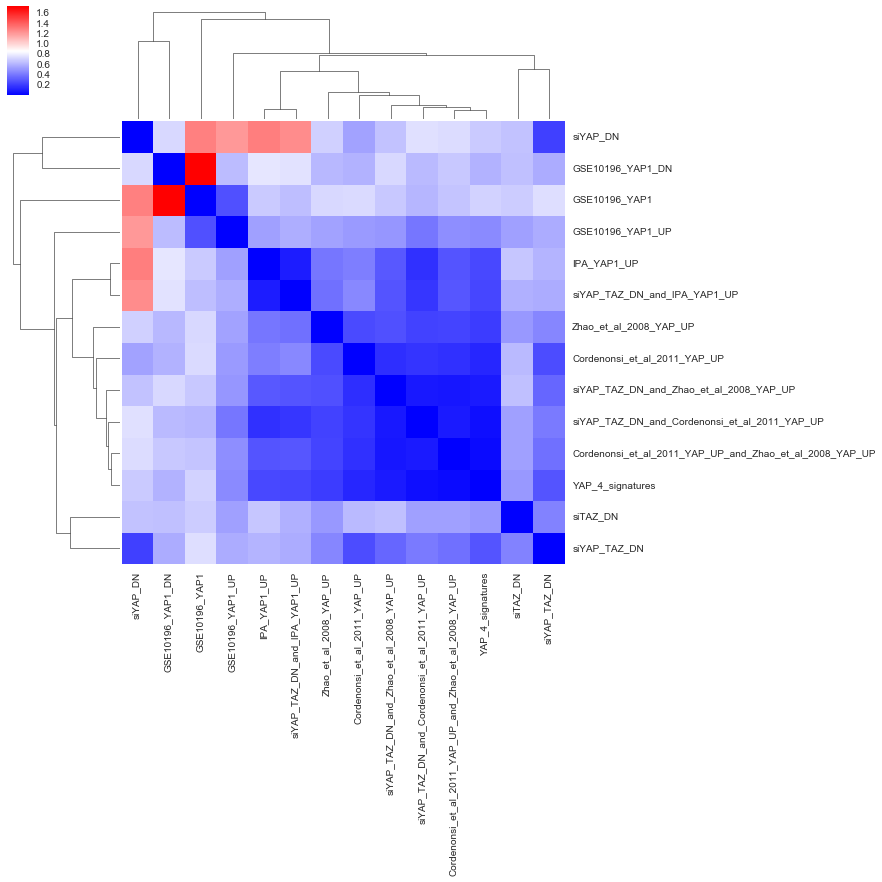

In [62]:
ccal.analyze.rank_features_against_features(features, features, distance=True)